# Tidal analysis
In this notebook we analyse the tidal spectrum of the tracer particles in the NWES and the intertial (MR advection) particles in the NWES to see whether we can measure "the intertia" of the particle from the tides.

In [69]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import circmean # for circular mean
import pickle # needed for reading in drifter data
from utide import solve
from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean, zonal_dist, meridional_dist
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'

basefile_tracer = (base_directory + '{particle_folder}/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_{land_handling}.zarr')

basefile_inertia =  (base_directory + '{particle_folder}/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}.zarr')

particle_types = ['tracer','MR','MRSM']
particle_folders = {'tracer':'tracer','MR':'inertial','MRSM':'inertial_SM'}
basefiles = {'tracer':basefile_tracer, 'MR':basefile_inertia, 'MRSM':basefile_inertia}


dims = {}
dims['MR'] ={'lon':'lon_MR', 'lat':'lat_MR','time':'time_MR'}
dims['tracer'] ={'lon':'lon_tracer', 'lat':'lat_tracer','time':'time_tracer'}
dims['MRSM'] ={'lon':'lon_MRSM', 'lat':'lat_MRSM','time':'time_MRSM'}


periods_tides = {
    'M2':360/28.9841042,
    'S2':360/30,
    'K1':360/15.0410686,
    'M4':360/57.9682084,
    'M6':360/86.9523127,
    'K2':360/30.0821373,
    'N2':360/28.4397295
}


In [70]:
# functions needed to handle drifter data
def open_dict(path, file):
    with open(f'{path}/{file}.pkl', 'rb') as f:
        dict = pickle.load(f)
    return dict

def from_string_to_timedelta(time_string, time_format= '%Y-%m-%dT%H:%M:%S'):
    return datetime.strptime(time_string,time_format)


vfrom_string_to_timedelta = np.vectorize(from_string_to_timedelta)

def get_seconds(timediff):
    return timediff.total_seconds()
vget_seconds= np.vectorize(get_seconds)

## Drifter data
We first look at the signal of the drifter data from the second release. The data is preprocessed by Jimena; it contains the velocity of the drifter calculated from its trajectory as well as the fluid velocity from the cmems dataset, sampled at the location of the particle. 


In [3]:
# read in drifter data
# use pickle for dataset
time_format ='%Y-%m-%dT%H:%M:%S'
path_drifters = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/drifter_data'
file_drifters_mid = 'Drifter_velocities_NWS_MidpointScheme'
drifter_data = open_dict(path_drifters,file_drifters_mid)

for key in drifter_data.keys():
    nptime = drifter_data[key]['Time']
    stringtime = np.datetime_as_string(nptime,'s')
    time = vfrom_string_to_timedelta(stringtime, time_format)
    drifter_data[key]['Time'] = time

print(drifter_data.keys())


dict_keys(['2430', '5450', '6530', '0510', '6520', '2400', '3450', '3510', '0520', '5490', '2500', '6480'])


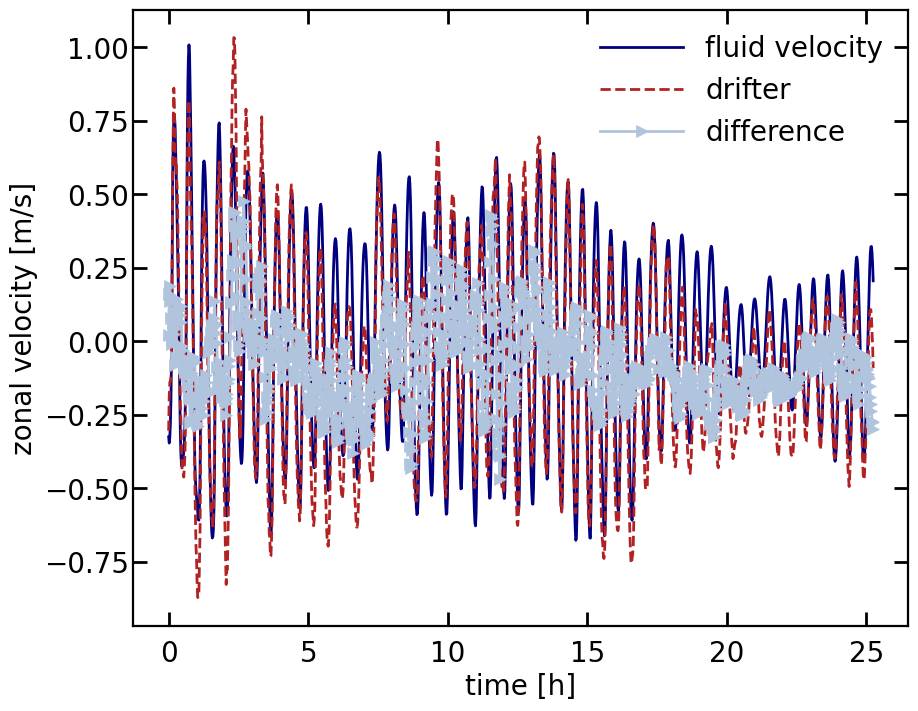

In [37]:
# plot velocities drifter together with 
drifter = drifter_data['2430']

seconds = vget_seconds(drifter['Time']-drifter['Time'][0])
fig,ax=plt.subplots()

start = 0#0
stop = 1200#1200#700

ax.plot(seconds[start:stop]/3600/24,drifter['U'][start:stop],color='navy')
ax.plot(seconds[start:stop]/3600/24,drifter['zonal_velocity'][start:stop],'--',color='firebrick')#-drifter['U'][0:1200])
ax.plot(seconds[start:stop]/3600/24,drifter['zonal_velocity'][start:stop]-drifter['U'][start:stop],'->',color='lightsteelblue')#-drifter['U'][0:1200])
# ax.plot(seconds[start:stop]/3600/24,drifter['zonal_velocity'][start:stop]-drifter['U'][start:stop],'-<',color='grey')#-drifter['U'][0:1200])
ax.set_xlabel('time [h]')
ax.set_ylabel('zonal velocity [m/s]')
ax.legend(['fluid velocity','drifter','difference'])
# ax.set_xlim(3,7)

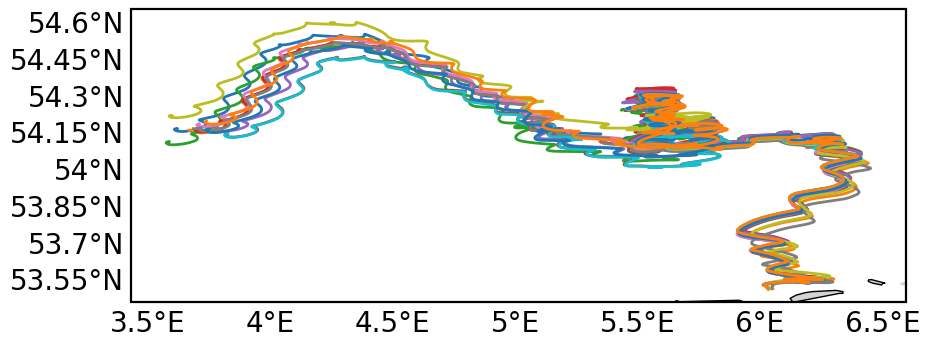

In [37]:
# plot drifter trajectories for selected time
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
for key in drifter_data.keys():
    drifter = drifter_data[key]
    ax.plot(drifter['Longitude'][start:stop],drifter['Latitude'][start:stop])
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}


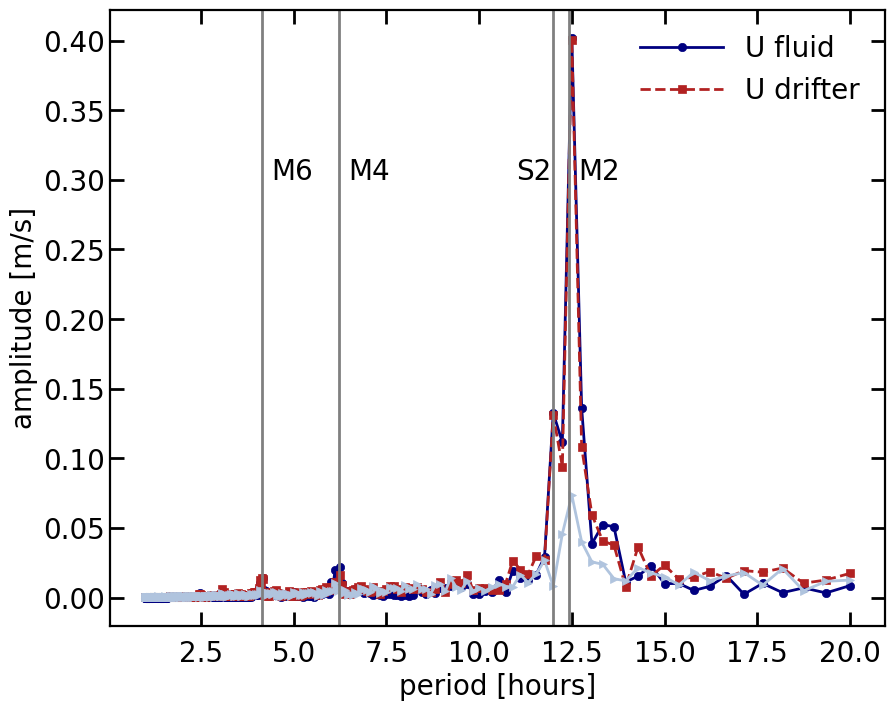

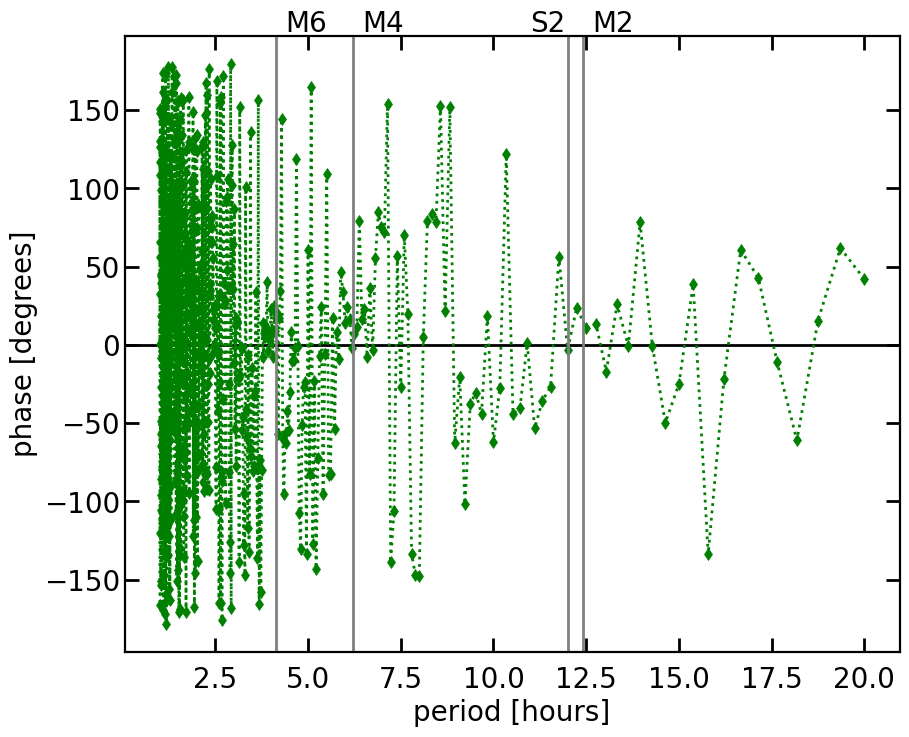

In [39]:
# range for time for plotting fourier spectrum
tmin = 1
tmax = 20

f_U_ampl_mean = np.zeros(stop-start)
f_V_ampl_mean = np.zeros(stop-start)
f_zv_ampl_mean =np.zeros(stop-start)
f_mv_ampl_mean =np.zeros(stop-start)
f_U_diff_ampl_mean = np.zeros(stop-start)
n=0
norm = 2/(stop-start)
max_angle= 2* np.pi /360
fig,ax=plt.subplots()
Ttotal = (stop-start)*0.5 #hours
dt = 0.5 #hour
freq = np.arange(0, Ttotal, dt) * 2 * np.pi / Ttotal / dt


n_freq_min= np.absolute(freq-2*np.pi/tmax).argmin()
n_freq_max= np.absolute(freq-2*np.pi/tmin).argmin()
n_freq_M2 = np.absolute(freq-2*np.pi/periods_tides['M2']).argmin()
n_freq_M4 = np.absolute(freq-2*np.pi/periods_tides['M4']).argmin()
n_freq_M6 = np.absolute(freq-2*np.pi/periods_tides['M6']).argmin()
n_freq_S2 = np.absolute(freq-2*np.pi/periods_tides['S2']).argmin()


M2U=[]
M2zv=[]
M2U_ph=[]
M2zv_ph=[]
U_ph=[]
U_diff_ph=[]
zv_ph=[]
U_diff_angle = []
U_diff_angle2 = []

for key in drifter_data.keys():
    drifter = drifter_data[key]
    seconds = vget_seconds(drifter['Time'][start:stop]-drifter['Time'][start])
    hours=seconds/3600
    hour_array=np.arange(0,stop-start,1)*0.5

    U_int=np.interp(hour_array,hours,drifter['U'][start:stop])
    zv_int=np.interp(hour_array,hours,drifter['zonal_velocity'][start:stop])
    V_int=np.interp(hour_array,hours,drifter['V'][start:stop])
    mv_int=np.interp(hour_array,hours,drifter['meridional_velocity'][start:stop])
    
    # fourier transform
    f_U = fft(U_int)
    f_zv = fft(zv_int)
    f_V = fft(V_int)
    f_mv = fft(mv_int)
    f_U_diff = fft(zv_int-U_int)

    #calculate average zmplitude 
    f_U_ampl_mean += norm * np.abs(f_U)
    f_V_ampl_mean += norm * np.abs(f_V)
    f_zv_ampl_mean += norm * np.abs(f_zv)
    f_mv_ampl_mean += norm * np.abs(f_mv)
    f_U_diff_ampl_mean += norm * np.abs(f_U_diff)

    #save phase (not averaged because we need to use circular mean for this)
    U_ph.append(np.angle(f_U))
    zv_ph.append(np.angle(f_zv))
    diff_angle = np.angle(f_zv)- np.angle(f_U) 
    diff_angle = np.where(diff_angle>np.pi,diff_angle-2*np.pi,diff_angle)
    diff_angle = np.where(diff_angle<-np.pi, 
                          diff_angle+2*np.pi,diff_angle)
    U_diff_angle.append(diff_angle)

    diff_angle2 = np.angle(f_U_diff)- np.angle(f_U) 
    diff_angle2 = np.where(diff_angle2>np.pi,diff_angle2-2*np.pi,diff_angle2)
    diff_angle2= np.where(diff_angle2<-np.pi, 
                          diff_angle2+2*np.pi,diff_angle2)
    U_diff_angle2.append(diff_angle2)

    U_diff_ph.append(np.angle(f_U_diff))

    # save M2 amplitude and phase
    M2U.append(norm * np.abs(f_U[n_freq_M2]))
    M2zv.append(norm * np.abs(f_zv[n_freq_M2]))
    M2U_ph.append(np.angle(f_U[n_freq_M2])/max_angle)
    M2zv_ph.append(np.angle(f_zv[n_freq_M2])/max_angle)

    n+=1

f_U_ampl_mean /= n
f_V_ampl_mean /= n
f_zv_ampl_mean /= n
f_mv_ampl_mean /= n
f_U_diff_ampl_mean /= n

#save as numpy array
M2zv=np.asarray(M2zv)
M2U=np.asarray(M2U)
M2zv_ph=np.asarray(M2zv_ph)
M2U_ph=np.asarray(M2U_ph)
U_ph = np.asarray(U_ph)
zv_ph = np.asarray(zv_ph)

# plot amplitude spectrum
ax.plot(2 * np.pi / (freq[n_freq_min:n_freq_max]),f_U_ampl_mean[n_freq_min:n_freq_max],'-o',color='navy',markersize=6)
ax.plot(2 * np.pi / (freq[n_freq_min:n_freq_max]),f_zv_ampl_mean[n_freq_min:n_freq_max],'--s',color='firebrick',markersize=6)
ax.plot(2 * np.pi / (freq[n_freq_min:n_freq_max]),f_U_diff_ampl_mean[n_freq_min:n_freq_max],'->',color='lightsteelblue',markersize=6)

ax.legend(['U fluid','U drifter'])
ax.axvline(periods_tides['M2'],color='gray')
ax.axvline(periods_tides['S2'],color='gray')
ax.axvline(periods_tides['M4'],color='gray')
ax.axvline(periods_tides['M6'],color='gray')
ax.text(periods_tides['M2']+0.25,0.3,'M2',fontsize='20')
ax.text(periods_tides['M4']+0.25,0.3,'M4',fontsize='20')
ax.text(periods_tides['M6']+0.25,0.3,'M6',fontsize='20')
ax.text(periods_tides['S2']-1.,0.3,'S2',fontsize='20')
ax.set_ylabel('amplitude [m/s]')
ax.set_xlabel('period [hours]')


# take correct average (circular mean)
U_ph_mean = circmean(U_ph,axis=0)
U_ph_mean = np.where(U_ph_mean>np.pi,U_ph_mean-2*np.pi,U_ph_mean)
zv_ph_mean = circmean(zv_ph,axis=0)
zv_ph_mean = np.where(zv_ph_mean>np.pi,zv_ph_mean-2*np.pi,zv_ph_mean)
U_diff_angle_mean = circmean(U_diff_angle,axis=0)
U_diff_angle_mean = np.where(U_diff_angle_mean>np.pi, U_diff_angle_mean-2*np.pi, U_diff_angle_mean)
U_diff_ph_mean = circmean(U_diff_ph,axis=0)
U_diff_ph_mean = np.where(U_diff_ph_mean>np.pi,U_diff_ph_mean-2*np.pi,U_diff_ph_mean)
U_diff_angle_mean2 = circmean(U_diff_angle2,axis=0)
U_diff_angle_mean2 = np.where(U_diff_angle_mean2>np.pi, U_diff_angle_mean2-2*np.pi, U_diff_angle_mean2)

# plot phase spectrum
fig2, ax2 = plt.subplots()
# ax2.plot(2 * np.pi / freq[n_freq_min:n_freq_max],U_ph_mean[n_freq_min:n_freq_max]/max_angle,'-o',color='navy',markersize=6)
# ax2.plot(2 * np.pi / freq[n_freq_min:n_freq_max],zv_ph_mean[n_freq_min:n_freq_max]/max_angle,'--s',color='firebrick',markersize=6)
# ax2.plot(2 * np.pi / freq[n_freq_min:n_freq_max],U_diff_angle_mean2[n_freq_min:n_freq_max]/max_angle,'->',color='lightsteelblue',markersize=6)
ax2.plot(2 * np.pi / freq[n_freq_min:n_freq_max],U_diff_angle_mean[n_freq_min:n_freq_max]/max_angle,':d',color='green',markersize=6)
# ax2.legend(['U fluid','U drifter','U drifter - U fluid'])


ax2.axvline(periods_tides['M2'],color='gray')
ax2.axvline(periods_tides['S2'],color='gray')
ax2.axvline(periods_tides['M4'],color='gray')
ax2.axvline(periods_tides['M6'],color='gray')
ax2.text(periods_tides['M2']+0.25,200,'M2',fontsize='20')
ax2.text(periods_tides['M4']+0.25,200,'M4',fontsize='20')
ax2.text(periods_tides['M6']+0.25,200,'M6',fontsize='20')
ax2.text(periods_tides['S2']-1.,200,'S2',fontsize='20')
ax2.set_ylabel('phase [degrees]')
ax2.set_xlabel('period [hours]')
ax2.axhline(0,color='black',zorder=-20)

phase difference M2 (degrees) = 16.43041566016216
phase difference S2 (degrees) = 11.338905052814525
phase difference M4 (degrees) = 3.4630704609014047
phase difference M6 (degrees) = 36.372757984155186


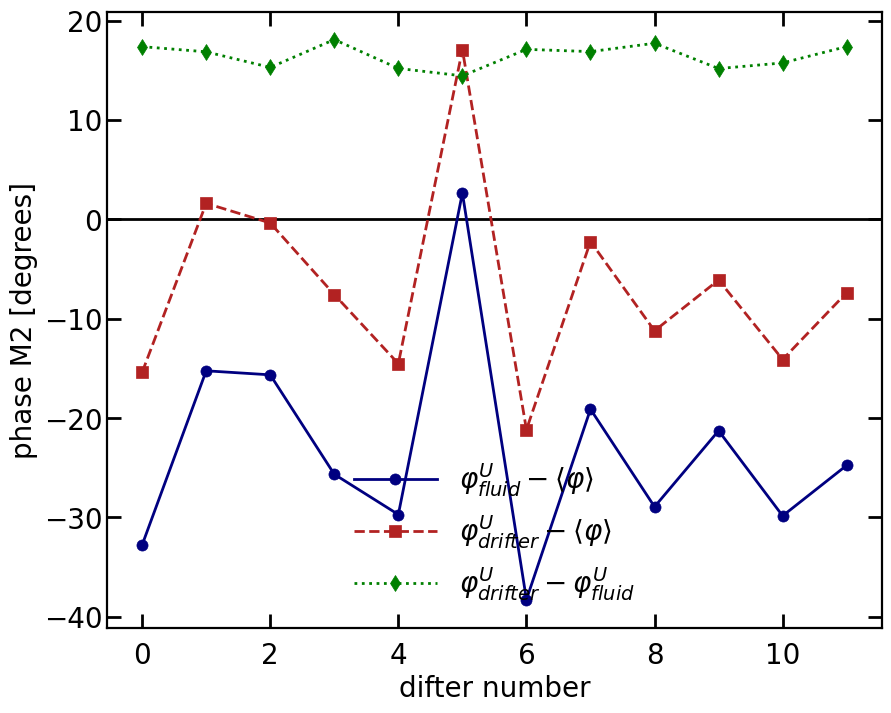

In [390]:
# print(f'phase diff (U_diff_angle_mean[n_freq_M2]/max_angle')
print(f'phase difference M2 (degrees) = {U_diff_angle_mean[n_freq_M2]/max_angle}')
print(f'phase difference S2 (degrees) = {U_diff_angle_mean[n_freq_S2]/max_angle}')
print(f'phase difference M4 (degrees) = {U_diff_angle_mean[n_freq_M4]/max_angle}')
print(f'phase difference M6 (degrees) = {U_diff_angle_mean[n_freq_M6]/max_angle}')

# phase difference for different drifters quite stable (phase drifter is always bigger than phase fluid)
fig,ax=plt.subplots()
M2U_ph_av = M2U_ph-np.mean(M2zv_ph+M2U_ph)/2
M2U_ph_av = np.where(M2U_ph_av<-180,M2U_ph_av+360,M2U_ph_av)
M2U_ph_av = np.where(M2U_ph_av>+180,M2U_ph_av-360,M2U_ph_av)
M2zv_ph_av = M2zv_ph-np.mean(M2zv_ph+M2U_ph)/2
M2zv_ph_av = np.where(M2zv_ph_av<-180,M2zv_ph_av+360,M2zv_ph_av)
M2Uzv_ph_av = np.where(M2zv_ph_av>+180,M2zv_ph_av-360,M2zv_ph_av)

ax.plot(M2U_ph_av,'-o',color='navy')
ax.plot(M2zv_ph_av,'--s',color='firebrick')
diffM2 = M2zv_ph-M2U_ph
diffM2 = np.where(diffM2<-180,diffM2+360,diffM2)
ax.plot(diffM2,':d',color='green')
ax.legend(['$\\varphi^U_{fluid}-\\langle \\varphi\\rangle$','$\\varphi^U_{drifter}-\\langle \\varphi\\rangle$','$\\varphi^U_{drifter}-\\varphi^U_{fluid}$'])
ax.set_xlabel('difter number')
ax.set_ylabel('phase M2 [degrees]')
ax.axhline(0,color='black',zorder=-10)

0.9963256505614632


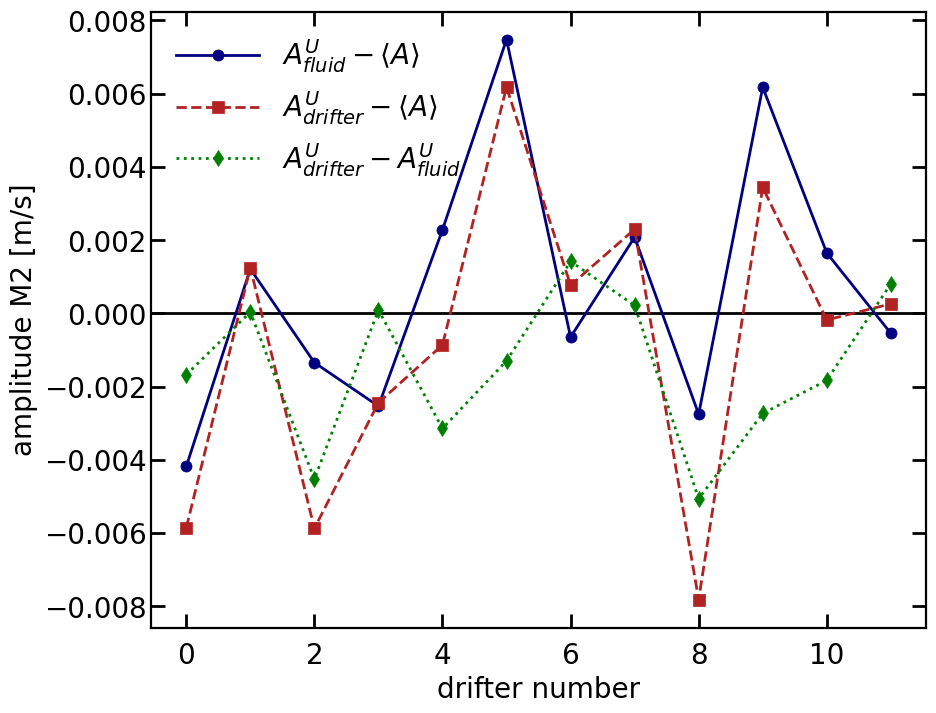

In [42]:
# plot amplitude difference M2 (not a clear signal?)

fig,ax=plt.subplots()
ax.plot(M2U-np.mean(M2U+M2zv)/2,'-o',color='navy')
ax.plot(M2zv-np.mean(M2U+M2zv)/2,'--s',color='firebrick')
ax.plot(M2zv-M2U,':d',color='green')

ax.set_xlabel('drifter number')
ax.set_ylabel('amplitude M2 [m/s]')
ax.legend(['$A^U_{fluid}-\\langle A \\rangle $','$A^U_{drifter}-\\langle A \\rangle $','$A^U_{drifter}-A^U_{fluid}$'])
ax.axhline(0,color='black',zorder=-10)
print(np.mean(M2zv/M2U))

## least square harmonic analysis with utide


In [44]:
latmean=54
coef_drifter_vel = solve(
    drifter_data['2430']['Time'],
    drifter_data['2430']['zonal_velocity'],
    lat=54,
    nodal=False,
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=0.95)

coef_drifter_Uflow= solve(
    drifter_data['2430']['Time'],
    np.array(drifter_data['2430']['U']),
    lat=54,
    nodal=False,
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=0.95)


solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.


0.97354320315155


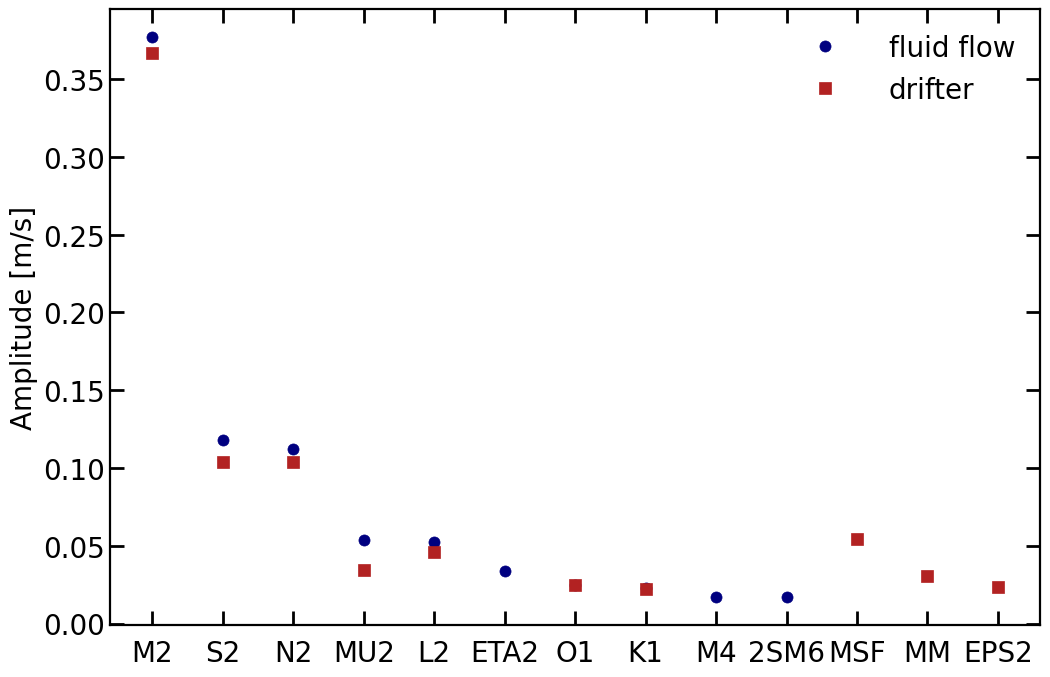

In [47]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(coef_drifter_Uflow.name[0:10],coef_drifter_Uflow.A[0:10],'o',color='navy')
ax.plot(coef_drifter_vel.name[0:10],coef_drifter_vel.A[0:10],'s',color='firebrick')
ax.set_ylabel('Amplitude [m/s]')
ax.legend(['fluid flow','drifter'])
print(coef_drifter_vel.A[0]/coef_drifter_Uflow.A[0])

-12.47487680393948


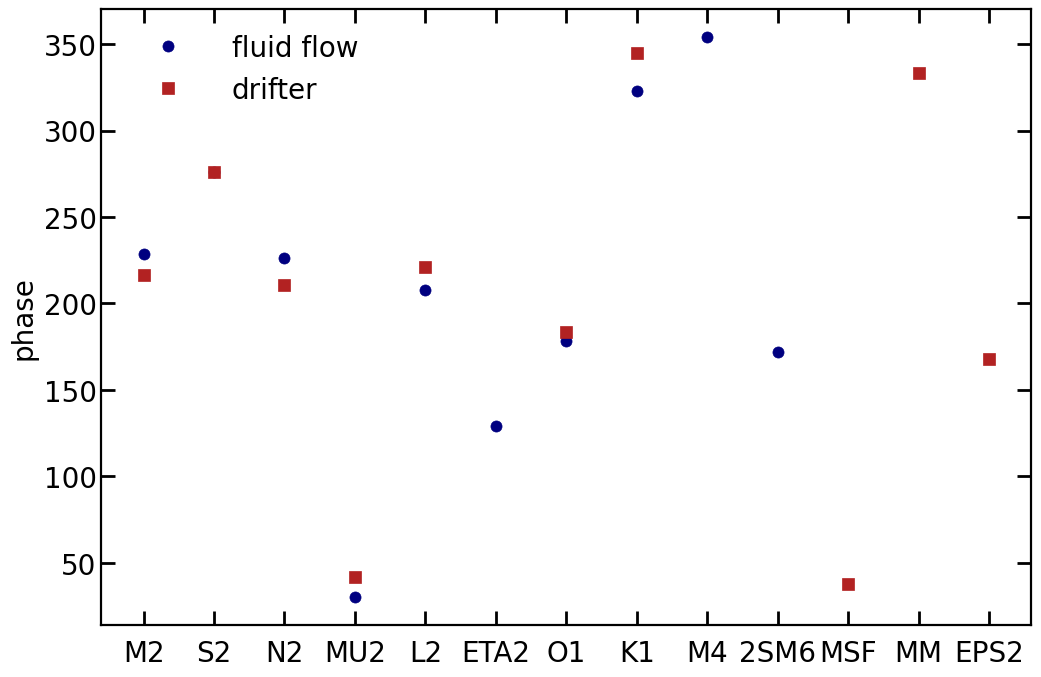

In [49]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(coef_drifter_Uflow.name[0:10],coef_drifter_Uflow.g[0:10],'o',color='navy')
ax.plot(coef_drifter_vel.name[0:10],coef_drifter_vel.g[0:10],'s',color='firebrick')
ax.set_ylabel('phase')
print(coef_drifter_vel.g[0]-coef_drifter_Uflow.g[0])
ax.legend(['fluid flow','drifter'])

In [75]:
print(coef_drifter_vel.g[0]-coef_drifter_Uflow.g[0])
print(coef_drifter_vel.A[0]/coef_drifter_Uflow.A[0])

-12.47487680393948
0.97354320315155


In [60]:
coef_drifter_Uflow

{'name': array(['M2', 'S2', 'N2', 'L2', 'MU2', 'MSF', 'ETA2', 'MM', 'O1', 'K1',
        'M4', '2SM6', 'M6', '2MS6', 'EPS2', 'MS4', '2Q1', 'Q1', 'MN4',
        'J1', 'S4', '2MN6', 'SN4', 'M8', 'M3', 'OO1', 'ALP1', 'NO1', 'MO3',
        'MK3', 'UPS1', '3MK7', 'SK3', '2SK5', '2MK5'], dtype=object),
 'aux': {'frq': array([0.0805114 , 0.08333333, 0.07899925, 0.08202355, 0.07768947,
         0.00282193, 0.08507364, 0.00151215, 0.03873065, 0.04178075,
         0.1610228 , 0.24717807, 0.2415342 , 0.24435613, 0.07617732,
         0.16384473, 0.03570635, 0.0372185 , 0.15951065, 0.0432929 ,
         0.16666667, 0.24002205, 0.16233258, 0.3220456 , 0.1207671 ,
         0.04483084, 0.03439657, 0.04026859, 0.11924206, 0.12229215,
         0.04634299, 0.28331495, 0.12511408, 0.20844741, 0.20280355]),
  'lind': array([ 47,  56,  41,  53,  39,   5,  60,   4,  12,  20,  81, 112, 105,
         109,  34,  85,   8,  10,  78,  24,  88, 102,  83, 124,  68,  27,
           7,  15,  67,  71,  28, 119,  73,  98,

In [52]:
print(np.array(drifter_data['2430']['Time']).size)

1620


## simulation analysis  
comparing tracer particle with MR praticle

In [6]:
# general settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
runtime=timedelta(30)
nparticles = 88347 # 52511
displacement = 100 #m
land_handling = 'anti_beaching'

starttimes = np.array([datetime(2023, 9, 1, 0, 0, 0, 0)]) #,
                    #    datetime(2023, 10, 1, 0, 0, 0, 0),
                    #    datetime(2023, 11, 1, 0, 0, 0, 0),
                    #    datetime(2023, 12, 1, 0, 0, 0, 0) ])#,
                       #datetime(2024, 1, 1, 0, 0, 0, 0),
                       #datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)




In [7]:
chunck_time = 100
years = np.array([2023,2024])
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
data = {}

data[2023] = {}
data[2024] = {}

traj = np.arange(0,nparticles,1)
dslist=[]
for starttime in starttimes:
    print(starttime)
    endtime = starttime + runtime 
    for ptype in particle_types:
        file = basefiles[ptype].format(particle_folder=particle_folders[ptype],
                                       loc=loc,
                                       y_s=starttime.year,
                                       m_s=starttime.month,
                                       d_s=starttime.day,
                                       y_e=endtime.year,
                                       m_e=endtime.month,
                                       d_e=endtime.day,
                                       B = int(B * 1000), 
                                       tau = int(tau ),
                                       land_handling = land_handling)

        ds = xr.open_dataset(file,
                             engine='zarr',
                             chunks={'trajectory':nparticles, 'obs':chunck_time},
                             drop_variables=['B','tau','z','vorticity'],
                             decode_times=True) #,decode_cf=False)

        ds = ds.rename(dims[ptype])
        dslist.append(ds)
    
    data[starttime.year][starttime.month] = xr.merge(dslist)



2023-09-01 00:00:00


In [8]:
# select particle that is close to drifter release particles
ds = data[2023][9]
lat_select = drifter_data['2430']['Latitude'][300]
lon_select = drifter_data['2430']['Longitude'][300]

index_select=np.absolute((ds['lon_tracer'][:,0]-lon_select)**2+(ds['lat_tracer'][:,0]-lat_select)**2).values.argmin()
print(index_select)

49420


Text(0, 0.5, 'latitude [$^{\\circ}$]')

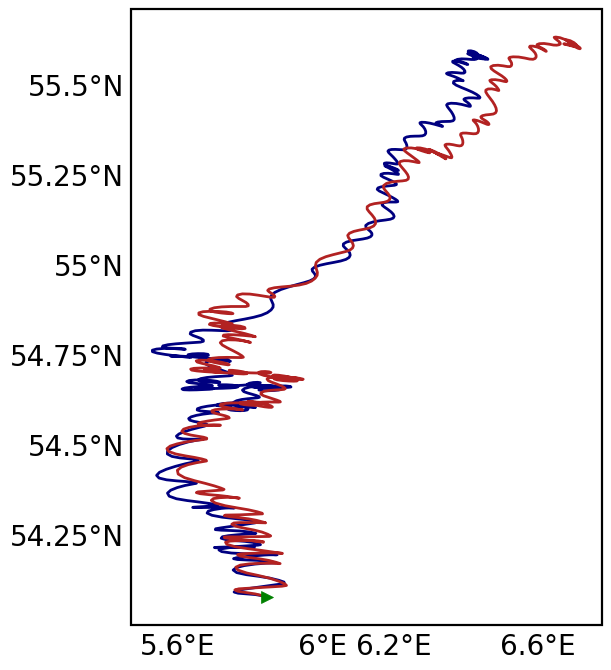

In [60]:
year=2023
month=9


ds = data[year][month]

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()

index= index_select # 1235 8537 20 66
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(ds['lon_tracer'][index,0].values,
        ds['lat_tracer'][index,0].values,
        '>',
        color='green',
        zorder=20)
ax.plot(ds['lon_tracer'][index,0::1].values,
        ds['lat_tracer'][index,0::1].values,
        '-',
        color='navy');

# ax.plot(ds['lon_MRSM'][index,0::1].values,
#         ds['lat_MRSM'][index,0::1].values,
#         '-',
#         color='red');

ax.plot(ds['lon_MR'][index,0::1].values,
        ds['lat_MR'][index,0::1].values,
        '-',
        color='firebrick');





gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
# ax.set_xlim(-8,-6)
# ax.set_ylim(55.5,58)

# ax.set_xlim(-8,-6)
# ax.set_ylim(55.5,58)
ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')


In [61]:
ds = data[year][month]
tend = 720
UV_names = {}
UV_names['MR']={'U':'U_MR','V':'V_MR'}
UV_names['MRSM']={'U':'U_MRSM','V':'V_MRSM'}
UV_names['tracer']={'U':'U_tracer','V':'V_tracer'}
delta_t = 2.
for ptype in particle_types:

    U = zonal_dist(lon1 = ds[f'lon_{ptype}'][:,0:-2].values,
               lon2 = ds[f'lon_{ptype}'][:,2:].values,
               lat = ds[f'lat_{ptype}'][:,1:-1].values) / delta_t
    U = np.insert(U,0,np.nan,axis=1)
    U = np.insert(U,799,np.nan,axis=1)
    
    V = meridional_dist(lat1 = ds[f'lat_{ptype}'][:,0:-2].values,
               lat2 = ds[f'lat_{ptype}'][:,2:].values) /delta_t
    V = np.insert(V,0,np.nan,axis=1)
    V = np.insert(V,799,np.nan,axis=1)
    # dtest = data[year][month].assign( test =  U)

    data[year][month] = data[year][month].assign(U=(['trajectory','obs'],U))
    data[year][month] = data[year][month].assign(V=(['trajectory','obs'],V))
    data[year][month]=data[year][month].rename(UV_names[ptype])



ValueError: the new name 'U_tracer' conflicts

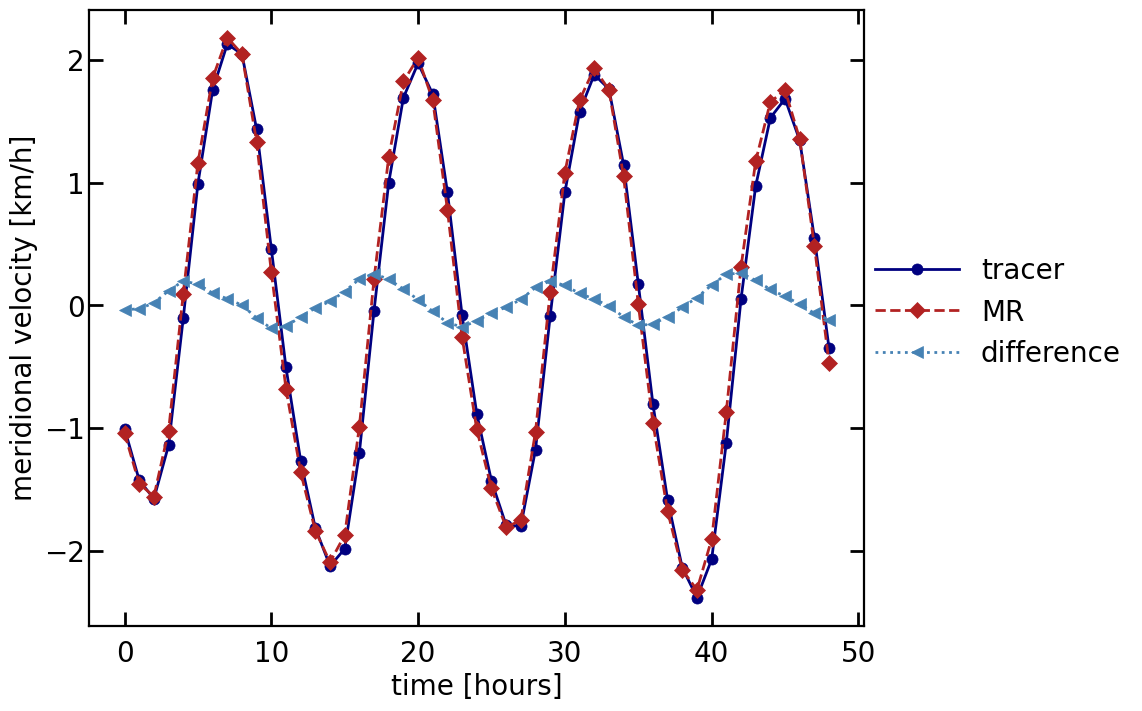

In [13]:
# fourier transform tidal spectrum simuations 
fig, ax = plt.subplots()
tlist = np.arange(0,49,1)
index= index_select
ax.plot( tlist,data[year][month].U_tracer[index,1:50],'-o',color='navy')


ax.plot( tlist,data[year][month].U_MR[index,1:50],'--D',color='firebrick')

ax.plot(tlist, ( data[year][month].U_MR[index,1:50]-data[year][month].U_tracer[index,1:50]),':<',color='steelblue')
# ax2.set_ylim(-0.2,0.2)
# ax.set_ylim(-2,2)

ax.set_xlabel('time [hours]')
ax.set_ylabel('meridional velocity [km/h]')#
ax.legend(['tracer','MR','difference'],loc=(1,0.4))


58
phase difference M2 (degrees) = 5.07276100600096
phase difference S2 (degrees) = 4.10815388008757
phase difference M4 (degrees) = 4.76776573880321
phase difference M6 (degrees) = 4.9527067709596455


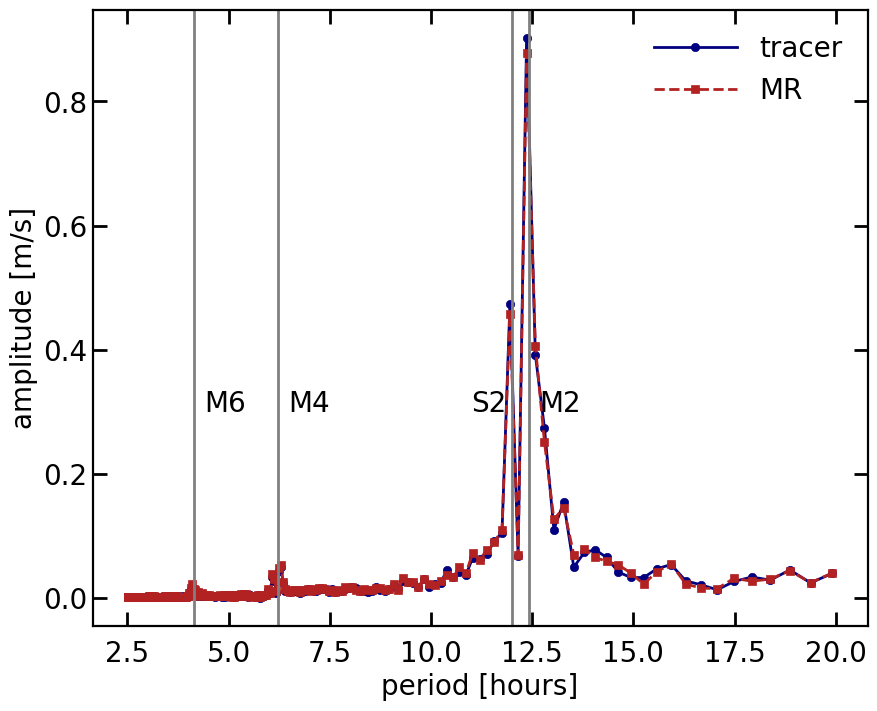

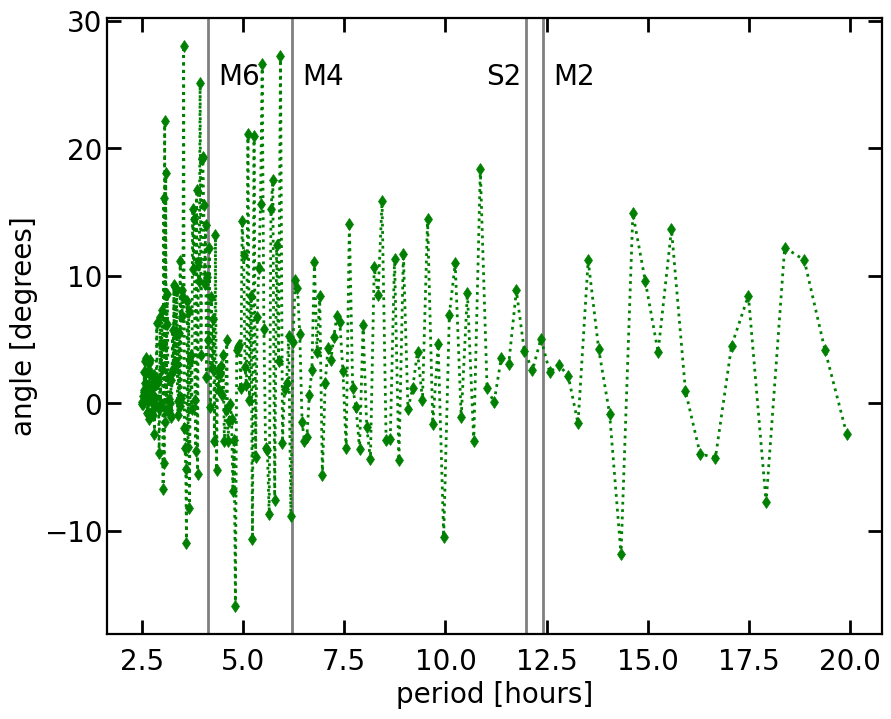

In [ ]:
# fourier spectrum

fig, ax = plt.subplots()

Ttotal = 717 #hours
dt = 1 #hour
freq=np.arange(0,Ttotal,dt)*2*np.pi/Ttotal /dt
tmin = 2.5
tmax = 20
n_freq_min= np.absolute(freq-2*np.pi/tmax).argmin()
n_freq_max= np.absolute(freq-2*np.pi/tmin).argmin()
n_freq_M2 = np.absolute(freq-2*np.pi/periods_tides['M2']).argmin()
n_freq_M4 = np.absolute(freq-2*np.pi/periods_tides['M4']).argmin()
n_freq_M6 = np.absolute(freq-2*np.pi/periods_tides['M6']).argmin()
n_freq_S2 = np.absolute(freq-2*np.pi/periods_tides['S2']).argmin()
print(n_freq_M2)
norm = 2/Ttotal
u_tracer = data[year][month].U_tracer[index,1:718].values
v_tracer = data[year][month].V_tracer[index,1:718].values
vel_tracer = u_tracer + 1j * v_tracer
uf_tracer = fft(u_tracer)
vf_tracer = fft(v_tracer)
velf_tracer = fft(vel_tracer)

u_MR = data[year][month].U_MR[index,1:718].values
v_MR = data[year][month].V_MR[index,1:718].values
vel_MR = u_MR + 1j * v_MR
uf_MR = fft(u_MR)
vf_MR = fft(v_MR)
velf_MR = fft(vel_MR)

u_MRSM = data[year][month].U_MRSM[index,1:718].values
v_MRSM = data[year][month].V_MRSM[index,1:718].values
vel_MRSM = u_MRSM + 1j * v_MRSM
uf_MRSM = fft(u_MRSM)
vf_MRSM = fft(v_MRSM)
velf_MRSM = fft(vel_MRSM)


max = 1 # np.max(np.abs(vf_tracer))
ax.plot(2 * np.pi / freq[n_freq_min:n_freq_max],norm * np.abs(uf_tracer)[n_freq_min:n_freq_max]/max,'-o',color='navy',markersize=6)

ax.plot(2 * np.pi / freq[n_freq_min:n_freq_max],norm * np.abs(uf_MR)[n_freq_min:n_freq_max]/max,'--s',color='firebrick',markersize=6)
ax.legend(['tracer','MR'])
ax.axvline(periods_tides['M2'],color='gray')
ax.axvline(periods_tides['S2'],color='gray')
ax.axvline(periods_tides['M4'],color='gray')
ax.axvline(periods_tides['M6'],color='gray')
ax.text(periods_tides['M2']+0.25,0.3,'M2',fontsize='20')
ax.text(periods_tides['M4']+0.25,0.3,'M4',fontsize='20')
ax.text(periods_tides['M6']+0.25,0.3,'M6',fontsize='20')
ax.text(periods_tides['S2']-1.,0.3,'S2',fontsize='20')
ax.set_ylabel('amplitude [m/s]')
ax.set_xlabel('period [hours]')

ax.set_xlabel('period [hours]')
ax.set_ylabel('amplitude [m/s]')




fig2, ax2 = plt.subplots()
max_angle= 2* np.pi / 360
# ax2.plot(2 * np.pi / freq[1:309],np.angle(vf_tracer)[1:309]/max_angle,'-o',color='navy',markersize=6)
# ax2.plot(2 * np.pi / freq[1:309],(np.angle(vf_MRSM)[1:309]-np.angle(vf_tracer)[1:309])/max_angle,'--s',color='firebrick',markersize=6)
phase_diff_u= (np.angle(uf_MR)-np.angle(uf_tracer))
phase_diff_u = np.where(phase_diff_u<-np.pi,phase_diff_u+2*np.pi,phase_diff_u)
phase_diff_u = np.where(phase_diff_u>np.pi,phase_diff_u-2*np.pi,phase_diff_u)
ax2.plot(2 * np.pi / freq[n_freq_min:n_freq_max],phase_diff_u[n_freq_min:n_freq_max]/max_angle,':d',color='green',markersize=6)

ax2.set_ylabel('angle [degrees]')
ax2.set_xlabel('period [hours]')
ax2.axvline(periods_tides['M2'],color='gray',zorder=-10)
ax2.axvline(periods_tides['S2'],color='gray',zorder=-10)
ax2.axvline(periods_tides['M4'],color='gray',zorder=-10)
ax2.axvline(periods_tides['M6'],color='gray',zorder=-10)
ax2.text(periods_tides['M2']+0.25,25,'M2',fontsize='20')
ax2.text(periods_tides['M4']+0.25,25,'M4',fontsize='20')
ax2.text(periods_tides['M6']+0.25,25,'M6',fontsize='20')
ax2.text(periods_tides['S2']-1.,25,'S2',fontsize='20')




print(f'phase difference M2 (degrees) = {phase_diff_u[n_freq_M2]/max_angle}')
print(f'phase difference S2 (degrees) = {phase_diff_u[n_freq_S2]/max_angle}')
print(f'phase difference M4 (degrees) = {phase_diff_u[n_freq_M4]/max_angle}')
print(f'phase difference M6 (degrees) = {phase_diff_u[n_freq_M6]/max_angle}')


# 12.4 h is betwen incex 57 and 58 

In [63]:
print(diff_angle/max_angle)
print((np.angle(vf_MR)[58]-np.angle(vf_tracer)[58])/max_angle)


[  0.         -33.98621792 -11.89700314 ...  -0.98928682  11.89700314
  33.98621792]
nan


## using least square tidal analysis (Utide)


In [66]:
year=2023
month=9


ds = data[year][month]
time = ds['time_tracer'][index_select].values
series_u = ds['U_tracer'][index_select].values
lat_mean=ds['lat_tracer'][index_select].mean().values
print(lat_mean)

coef_tracer = solve(
    time,
    series_u,
    lat=lat_mean,
    nodal=False,
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=0.95)



54.851128
solve: matrix prep ... solution ... done.


In [67]:
time = ds['time_MR'][index_select].values
series_u = ds['U_MR'][index_select].values
lat_mean=ds['lat_MR'][index_select].mean().values
print(lat_mean)

coef_MR = solve(
    time,
    series_u,
    lat=lat_mean,
    nodal=False,
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=0.95)

54.896385
solve: matrix prep ... solution ... done.


[1.00499749 0.44361478 0.24406487 0.10847924 0.10194807 0.06693258
 0.05347555 0.04894718 0.04495753 0.0439071  0.0225973  0.02126711
 0.02091232 0.01894598 0.01435665 0.0131832  0.01198112 0.01039931
 0.0093111  0.00886705 0.00537858 0.00528723 0.00527779 0.00490764
 0.00331954 0.00252524 0.00206501 0.00190316 0.00135886]
['M2' 'S2' 'N2' 'ETA2' 'MSF' 'O1' 'MS4' 'M4' 'K1' 'Q1' 'J1' 'MN4' '2MS6'
 'UPS1' 'M6' '2Q1' 'SK3' '2MN6' '2SM6' 'OO1' 'MK3' 'MO3' 'NO1' 'S4' '2MK5'
 'M3' '2SK5' 'M8' '3MK7']
[0.97733685 0.43406828 0.24939962 0.09610689 0.07836621 0.06093184
 0.05766792 0.05493878 0.0409793  0.03489513 0.02336221 0.0226869
 0.01920252 0.01655851 0.01616768 0.01494731 0.01323013 0.01153423
 0.01058779 0.00893796 0.00556752 0.00555063 0.00507424 0.0031059
 0.0021831  0.00211909 0.00192138 0.00162106 0.00097925]
['M2' 'S2' 'N2' 'ETA2' 'MSF' 'O1' 'MS4' 'M4' 'Q1' 'K1' 'MN4' '2MS6' 'J1'
 'M6' 'OO1' 'UPS1' '2MN6' 'SK3' '2SM6' '2Q1' 'S4' 'MK3' 'MO3' '2MK5'
 '2SK5' 'NO1' 'M8' '3MK7' 'M3']
0.97

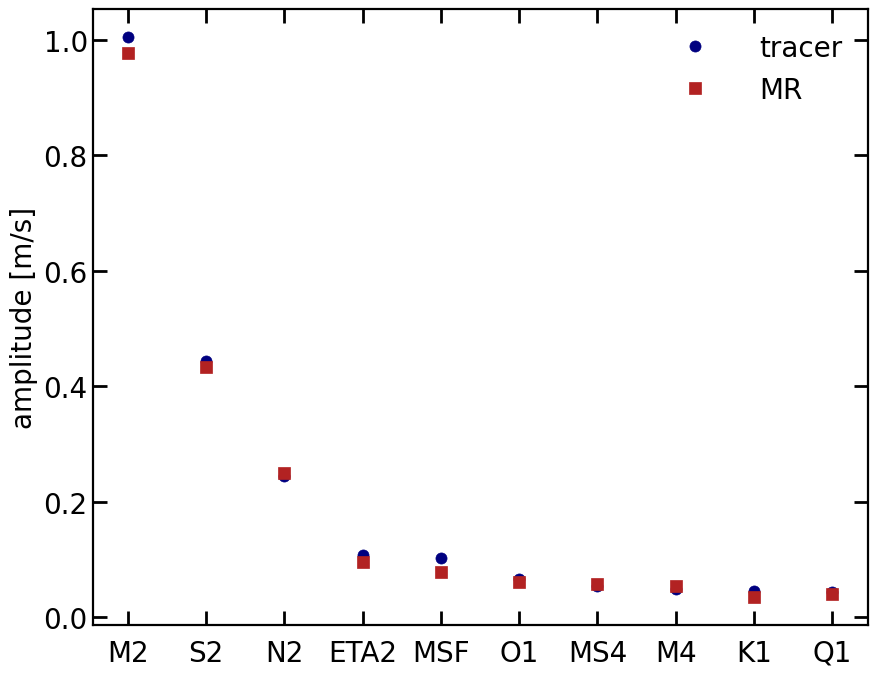

In [54]:
print(coef_tracer.A)
print(coef_tracer.name)
print(coef_MR.A)
print(coef_MR.name)

fig,ax=plt.subplots()
ax.plot(coef_tracer.name[0:10],coef_tracer.A[0:10],'o',color='navy')
ax.plot(coef_MR.name[0:10],coef_MR.A[0:10],'s',color='firebrick')
ax.set_ylabel('amplitude [m/s]')
ax.legend(['tracer','MR'])
print(coef_MR.A[0]/coef_tracer.A[0])

-4.1094864944335825


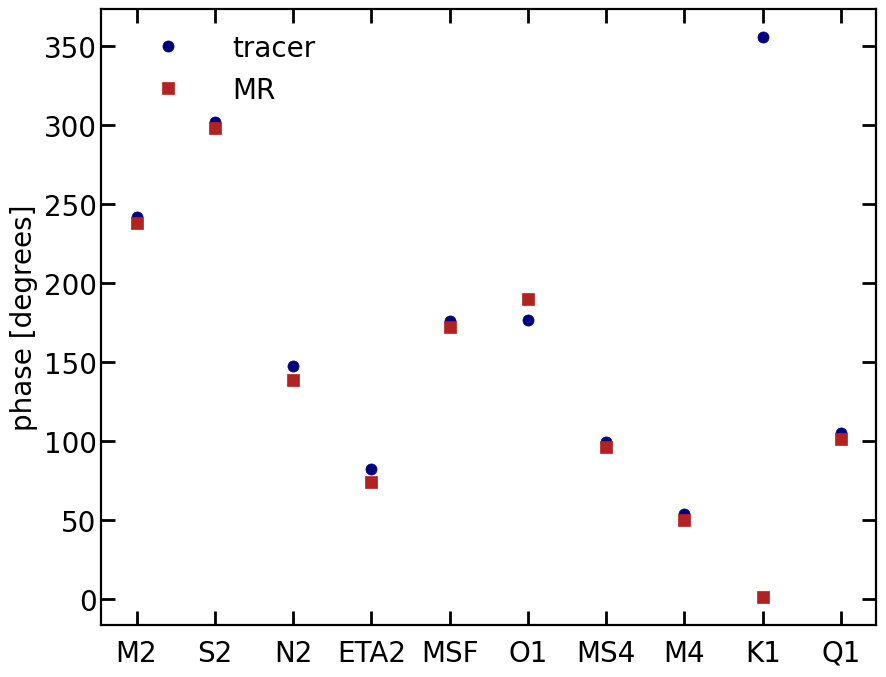

In [68]:
fig,ax=plt.subplots()
ax.plot(coef_tracer.name[0:10],coef_tracer.g[0:10],'o',color='navy')
ax.plot(coef_MR.name[0:10],coef_MR.g[0:10],'s',color='firebrick')
ax.set_ylabel('phase [degrees]')
ax.legend(['tracer','MR'])
print(coef_MR.g[0]-coef_tracer.g[0])



In [59]:
print(coef_MR.g[0]-coef_tracer.g[0])
print(coef_MR.A[0]/coef_tracer.A[0])

-4.1094864944335825
0.9724769112931404


# Analytical testcase periodic flow
Below we test the tidal analysis for the case where the flow is given by $u_f = A \cos ( \omega_0 t)$ with A = 1 m/s, $\omega_0 = 2 \pi / T_{M2}$ with $T_{M2} = 12.4$ h  
For this flow we can write the analytical expression of the particle velocities using the slow manifold maxey riley equation and the full MR equations. We also use parcels  
to advect particles with this velocity to see whether everything is correct. 


In [71]:
# full MR solution for up with uf = A cos (omega_0 t ) and up(t=0) = uf(t=0) = A 
def up_cos_tracer(t, A,  omega_0):
    """
    Function that describes a homogenous flow periodic (cosine) in time
    with amplitude A and angular frequency omega_0 = 2pi / T with T the period
    """
    return  A *  np.cos(t * omega_0)

def up_cos_MRSM(t, A, omega_0, tau, B):
    """
    Function that returns the full slow manifold MR solution of the   
    particle velocity for a fluid velocity with uf = A cos (omega_0 t)
    """
    return A *  np.cos(t * omega_0) - tau * omega_0 * 2 * (1 - B) / (2 * B + 1) * np.sin(t * omega_0)


def up_cos_MR(t, A, omega_0, tau, B):
    """
    Function that returns the full MR solution of the particle velocity
    for a fluid velocity with uf = A cos (omega_0 t) and up(t=0) = uf(t=0) = A
    """
    dev = A / (tau**2 * omega_0 **2 + 1)
    g_B = 3. / (2 * B +1)
    term1 =  (tau**2 * omega_0**2 * g_B + 1) * np.cos(omega_0 * t) 
    term2 =  tau * omega_0 * (1- g_B) * np.sin(omega_0 * t) 
    term3 = tau**2 * omega_0**2 * (1 - g_B) * np.exp(-t/tau)  
    up = dev * (term1 + term2 + term3) 
    return up

In [72]:
print(B)

0.68


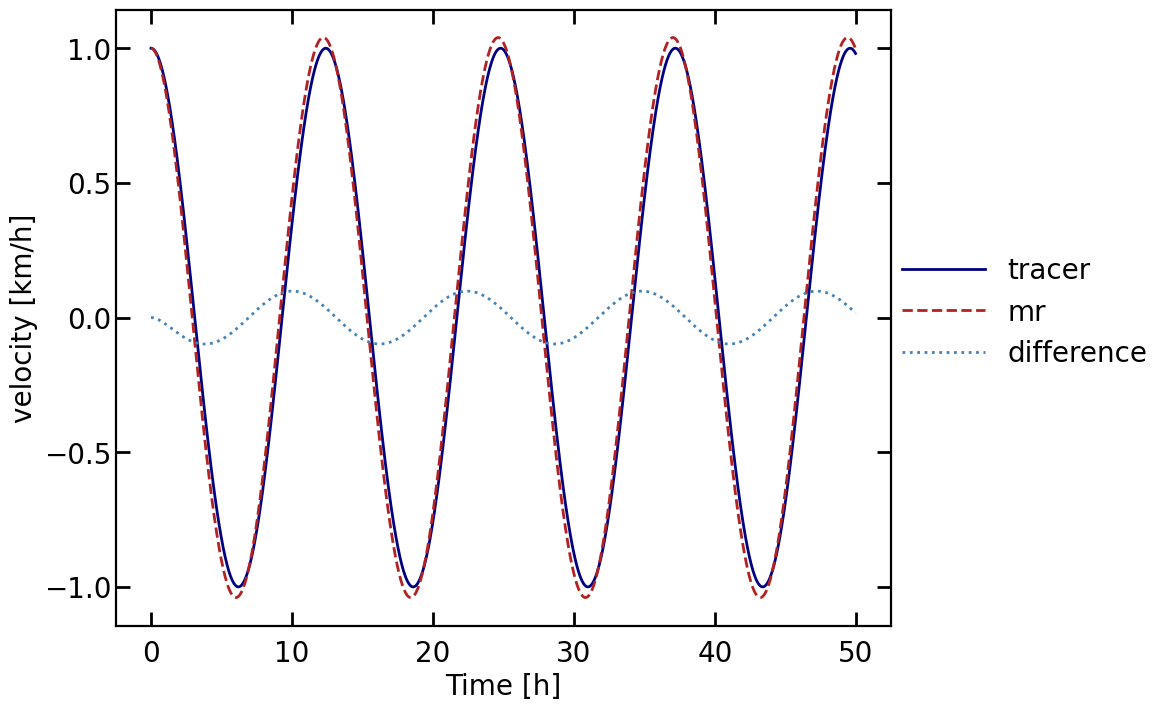

In [ ]:
T = 12.4 # h
omega_0 = 2 * np.pi / T
A = 1 # m/s
Ttotal = 50 # h
dt = 0.01 # h
tlist = np.arange(0,Ttotal,dt)


utest_tr = up_cos_tracer(tlist, A, omega_0)
utest_mrsm = up_cos_MRSM(tlist, A, omega_0, tau/3600, B)
utest_mr = up_cos_MR(tlist,A,omega_0, tau/3600 ,B)

fig, ax = plt.subplots()
ax.plot(tlist,utest_tr,'-',color='navy')

# ax.plot(tlist,utest_mrsm,'--',color='firebrick')
ax.plot(tlist,utest_mr,'--',color='firebrick')

# ax.plot(tlist,utest_mrsm-utest_tr,':',color='grey')
ax.plot(tlist,(utest_mr-utest_tr),':',color='steelblue')
ax.set_xlabel('Time [h]')
ax.set_ylabel('velocity [km/h]')
ax.legend(['tracer','mr','difference'],loc=(1,0.4))


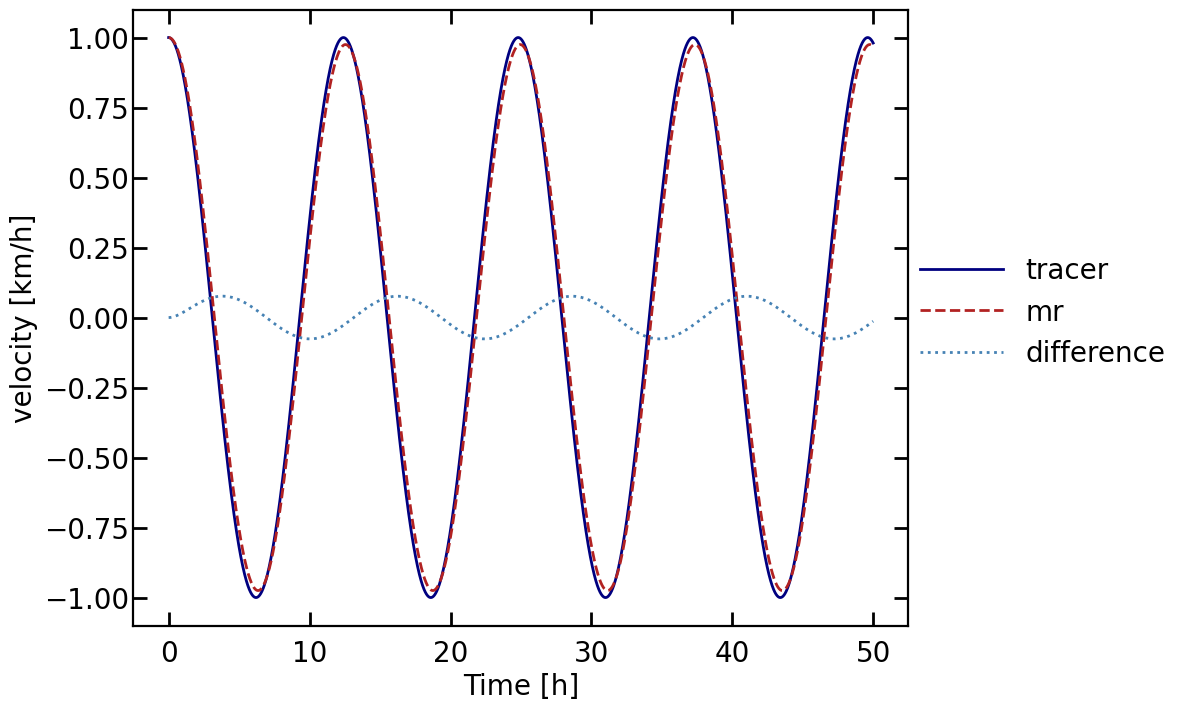

In [74]:
T = 12.4 # h
omega_0 = 2 * np.pi / T
A = 1 # m/s
Ttotal = 50 # h
dt = 0.01 # h
tlist = np.arange(0,Ttotal,dt)
B=1.4


utest_tr = up_cos_tracer(tlist, A, omega_0)
utest_mrsm = up_cos_MRSM(tlist, A, omega_0, tau/3600, B)
utest_mr = up_cos_MR(tlist,A,omega_0, tau/3600 ,B)

fig, ax = plt.subplots()
ax.plot(tlist,utest_tr,'-',color='navy')

# ax.plot(tlist,utest_mrsm,'--',color='firebrick')
ax.plot(tlist,utest_mr,'--',color='firebrick')

# ax.plot(tlist,utest_mrsm-utest_tr,':',color='grey')
ax.plot(tlist,(utest_mr-utest_tr),':',color='steelblue')
ax.set_xlabel('Time [h]')
ax.set_ylabel('velocity [km/h]')
ax.legend(['tracer','mr','difference'],loc=(1,0.4))


In [11]:
# parcels simulation of particle in this flow
from parcels import FieldSet, AdvectionRK4, ParticleSet, ParticleFile
sys.path.append("../simulations")
from kernels import InertialParticle2D, InitializeParticles2D, deleteParticle, MRAdvectionRK4_2D, MRSMAdvectionRK4_2D,MRAdvectionEC_2D


def cosine_fieldset(Lx, Ly, Tsim, Nt,  Nx, Ny, A, omega_0):
    lon = np.linspace(0, Lx , Nx, dtype=np.float64)
    lat = np.linspace(0, Ly , Ny, dtype=np.float64)
    time = np.linspace(0, Tsim, Nt, dtype=np.float64)
    t, y, x = np.meshgrid(time, lat, lon, indexing='ij')
    U = A * np.cos(omega_0 * t)
    V = 0 * t 
    data = {"U": U,  "V":V }
    dimensions= {"lon":lon, "lat":lat, "time":time}
    fieldset = FieldSet.from_data(data,dimensions,mesh="flat")
    return fieldset
fieldset = cosine_fieldset(Lx = 2000 , Ly = 2000, Tsim = 100, Nt = 201,  Nx = 5, Ny=5, A=1, omega_0 = 2*np.pi /T)

simulations = ['tracer','MR','MRSM']
filenames = {'tracer':'data/tracer_cos_flow.zarr','MR':'data/MR_cos_flow.zarr','MRSM':'data/MRSM_cos_flow.zarr'}
init_kernel = [InitializeParticles2D, deleteParticle]
kernels = {'tracer':[AdvectionRK4, deleteParticle],'MR':[MRAdvectionRK4_2D, deleteParticle],'MRSM':[MRSMAdvectionRK4_2D, deleteParticle]}
dt_timestep=0.5
for simulation in simulations:
    fieldset = cosine_fieldset(Lx = 2000 , Ly = 2000, Tsim = 100, Nt = 201,  Nx = 5, Ny=5, A=1, omega_0 = 2*np.pi /T)
    print('start simulation of ' + simulation)
    fieldset.add_constant('Omega_earth',0)

    # grid spacing
    Delta_x = 1
    Delta_y = 1
    Delta_t = dt_timestep

    # stepsize for finite differences calculation
    delta_x = 0.5 * Delta_x
    delta_y = 0.5 * Delta_y


    fieldset.add_constant('delta_x', delta_x)
    fieldset.add_constant('delta_y', delta_y)
    
    pset = ParticleSet.from_list(fieldset, InertialParticle2D, lon=1000,
                                    lat=1000, time=0,  B=B, tau=tau/3600)
    pset.execute(init_kernel,endtime =1, dt =1)
    pfile = ParticleFile(filenames[simulation], pset, outputdt=0.5)
    pset.execute(kernels[simulation],endtime = 51,dt=0.5, output_file =pfile)


start simulation of tracer
100%|██████████| 1.0/1.0 [00:00<00:00, 758.33it/s]
INFO: Output files are stored in data/tracer_cos_flow.zarr.
100%|██████████| 50.0/50.0 [00:04<00:00, 12.38it/s]
start simulation of MR
100%|██████████| 1.0/1.0 [00:00<00:00, 879.68it/s]
INFO: Output files are stored in data/MR_cos_flow.zarr.
100%|██████████| 50.0/50.0 [00:06<00:00,  7.53it/s]
start simulation of MRSM
100%|██████████| 1.0/1.0 [00:00<00:00, 875.27it/s]
INFO: Output files are stored in data/MRSM_cos_flow.zarr.
100%|██████████| 50.0/50.0 [00:05<00:00,  9.27it/s]


In [26]:
dslist=[]

simulations = ['tracer','MR','MRSM']
filenames = {'tracer':'data/tracer_cos_flow.zarr','MR':'data/MR_cos_flow.zarr','MRSM':'data/MRSM_cos_flow.zarr'}


for ptype in particle_types:
    ds = xr.open_dataset(filenames[ptype],engine='zarr')
    ds = ds.rename(dims[ptype])
    dslist.append(ds)
data_cos_flow = xr.merge(dslist)

In [27]:

tend = 100
UV_names = {}
UV_names['MR']={'U':'U_MR','V':'V_MR'}
UV_names['MRSM']={'U':'U_MRSM','V':'V_MRSM'}
UV_names['tracer']={'U':'U_tracer','V':'V_tracer'}
delta_t = 2.
for ptype in particle_types:

    U = data_cos_flow[f'lon_{ptype}'][:,2:].values-data_cos_flow[f'lon_{ptype}'][:,0:-2].values
    U = np.insert(U,0,np.nan,axis=1)
    U = np.insert(U,99,np.nan,axis=1)
    V = data_cos_flow[f'lat_{ptype}'][:,2:].values-data_cos_flow[f'lat_{ptype}'][:,0:-2].values
    V = np.insert(V,0,np.nan,axis=1)
    V = np.insert(V,99,np.nan,axis=1)

    # dtest = data[year][month].assign( test =  U)
    data_cos_flow = data_cos_flow.assign(U=(['trajectory','obs'],U))
    data_cos_flow = data_cos_flow.assign(V=(['trajectory','obs'],V))
    data_cos_flow=data_cos_flow.rename(UV_names[ptype])

NameError: name 'up_cos_tracer' is not defined

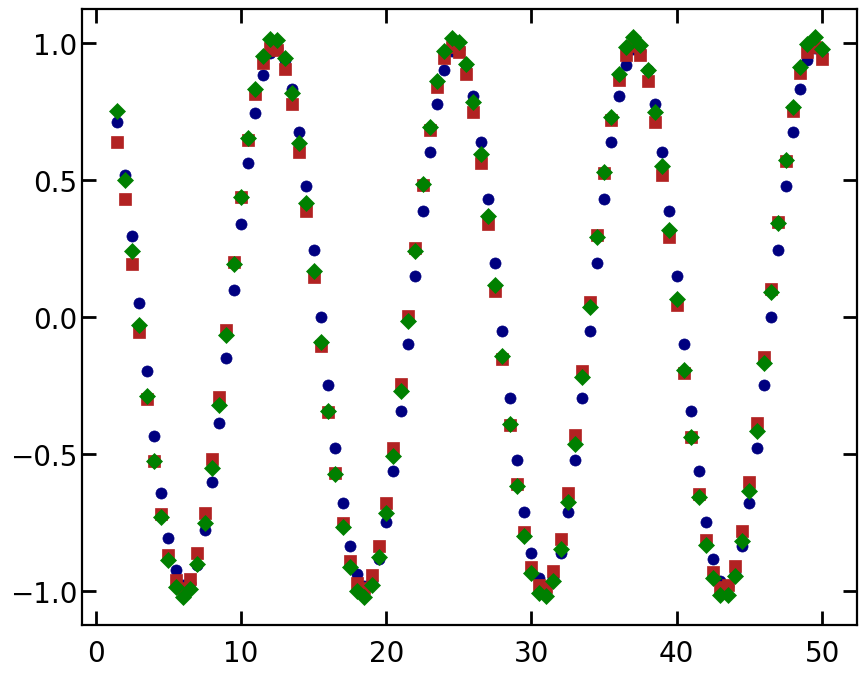

In [23]:
fig, ax = plt.subplots()
tlist = np.arange(1,51,0.5)
index=0
ax.plot( tlist,data_cos_flow.U_tracer[0,:],'o',color='navy')

ax.plot( tlist,data_cos_flow.U_MRSM[2,:],'s',color='firebrick')
ax.plot( tlist,data_cos_flow.U_MR[1,:],'D',color='green')

utest_tr = up_cos_tracer(tlist, A, omega_0)
utest_mrsm = up_cos_MRSM(tlist, A, omega_0, tau/3600, B)
utest_mr = up_cos_MR(tlist,A,omega_0, tau/3600 ,B)


ax.plot(tlist,utest_tr,'-',color='navy')

ax.plot(tlist,utest_mrsm,'--',color='firebrick')
ax.plot(tlist,utest_mr,'--',color='green')
# ax2= ax.twinx()
ax.plot(tlist, data_cos_flow.U_MRSM[2,:]-data_cos_flow.U_tracer[0,:],':>',color='grey')
ax.plot(tlist, ( data_cos_flow.U_MR[1,:]-data_cos_flow.U_tracer[0,:]),':<',color='steelblue')
# ax2.set_ylim(-0.2,0.2)
# ax.set_ylim(-2,2)

490
97
47.051204681396484
48.7244758605957
1.0432013
4.998813962951817
12.25


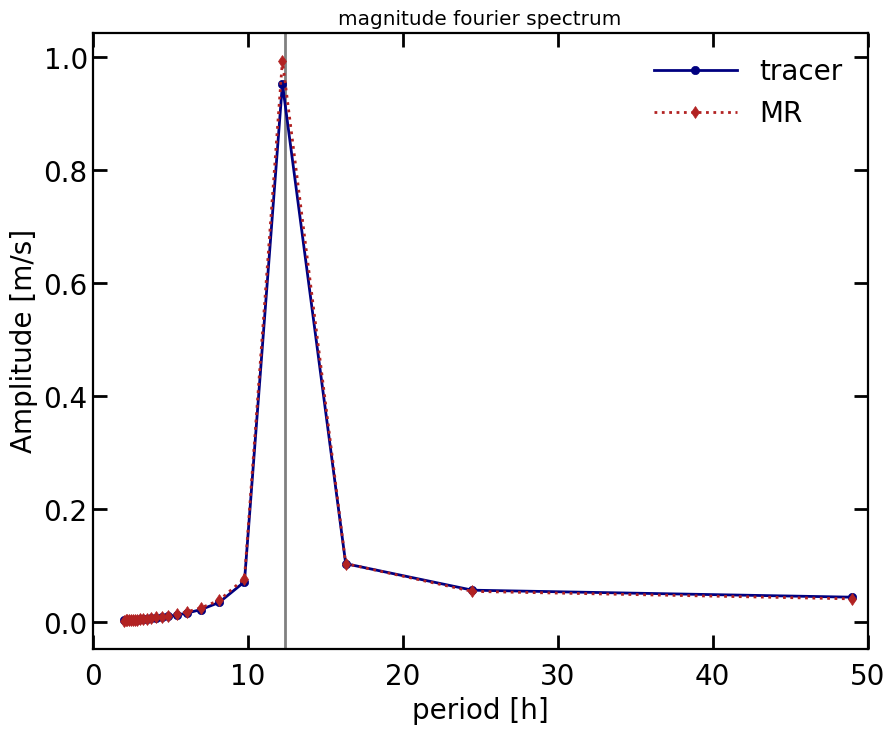

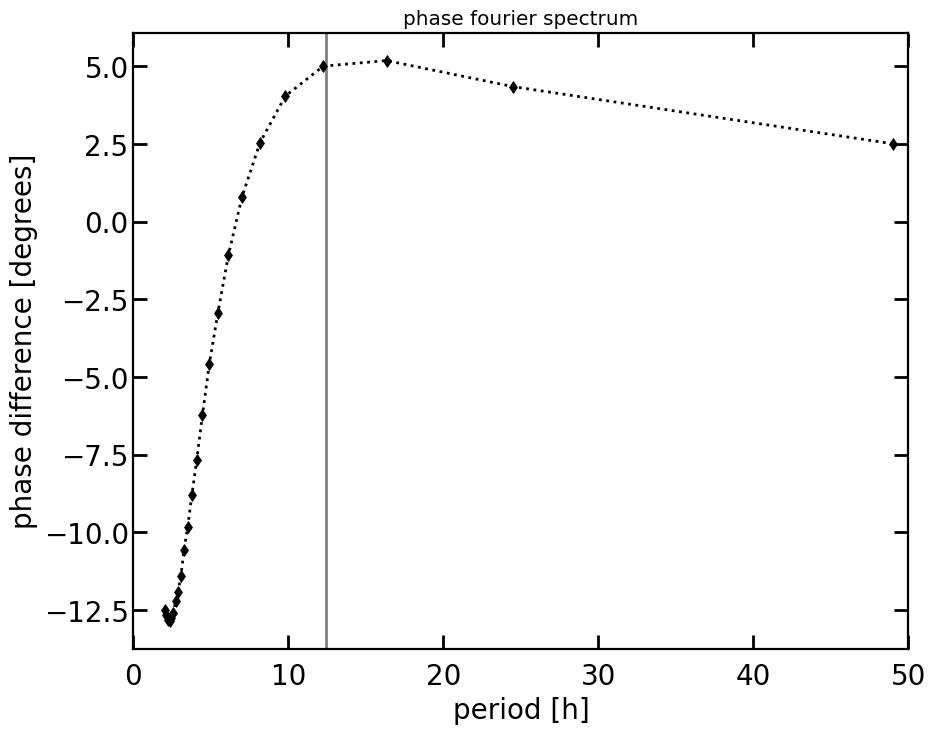

In [35]:
# fourier spectrum
fig, ax = plt.subplots()
Ttotal = 50-1 #hours
dt = 0.1 #hour
freq=np.arange(0,Ttotal,dt)*2*np.pi/Ttotal /dt
u_tracer = data_cos_flow.U_tracer.values[0,1:-2]
v_tracer = data_cos_flow.V_tracer.values[0,1:-2]
vel_tracer = u_tracer + 1j * v_tracer
uf_tracer = fft(u_tracer)
vf_tracer = fft(v_tracer)
norm = 1/Ttotal

velf_tracer = fft(vel_tracer)

u_MR = data_cos_flow.U_MR.values[1,1:-2]
v_MR = data_cos_flow.V_tracer.values[1,1:-2]
vel_MR = u_MR + 1j * v_MR
uf_MR = fft(u_MR)
vf_MR = fft(v_MR)
velf_MR = fft(vel_MR)

u_MRSM = data_cos_flow.U_MRSM.values[2,1:-2]
v_MRSM = data_cos_flow.V_MRSM.values[2,1:-2]
vel_MRSM = u_MRSM + 1j * v_MRSM
uf_MRSM = fft(u_MRSM)
vf_MRSM = fft(v_MRSM)
velf_MRSM = fft(vel_MRSM)

# ax.plot( np.abs(uf_MR),'--',color='navy')
# ax.plot(np.abs(vf_MR),'--',color='firebrick')
max = 1 # np.max(np.abs(vf_tracer))
print(freq.size)
print(vf_tracer.size)
ax.plot(2 * np.pi / freq[1:25],norm*np.abs(uf_tracer)[1:25]/max,'-o',color='navy',markersize=6)
# ax.plot(2 * np.pi / freq[1:309],np.abs(vf_MRSM)[1:309]/max,'--s',color='firebrick',markersize=6)
ax.plot(2 * np.pi / freq[1:25],norm*np.abs(uf_MR)[1:25]/max,':d',color='firebrick',markersize=6)
ax.legend(['tracer','MR'])
ax.axvline(T, color='grey',zorder=-20)
ax.set_xlim(0.,50)
ax.set_xlabel('period [h]')
ax.set_ylabel('Amplitude [m/s]')
print(np.max(np.abs(uf_MRSM)[0:25])/max)
print(np.max(np.abs(uf_MR)[0:25])/max)

amp_12_h4_ratio_analytical = np.max(np.abs(uf_MR)[0:25])/np.max(np.abs(uf_tracer)[0:25])
print(amp_12_h4_ratio_analytical)
ax.set_title('magnitude fourier spectrum')

fig2, ax2 = plt.subplots()
max_angle= 2* np.pi /360
# ax2.plot(2 * np.pi / freq[1:309],np.angle(vf_tracer)[1:309]/max_angle,'-o',color='navy',markersize=6)
# ax2.plot(2 * np.pi / freq[1:309],(np.angle(vf_MRSM)[1:309]-np.angle(vf_tracer)[1:309])/max_angle,'--s',color='firebrick',markersize=6)

ax2.plot(2 * np.pi / freq[1:25],(np.angle(uf_MR)[1:25]-np.angle(uf_tracer)[1:25])/max_angle,':d',color='black',markersize=6)

ax2.set_title('phase fourier spectrum')
ax2.set_xlabel('period [h]')
ax2.set_ylabel('phase difference [degrees]')
# ax2.legend(['tracer','slow manifold MR','MR'])
# ax2.legend(['MR'])
ax2.axvline(T, color='grey',zorder=-20)
ax2.set_xlim(0.,50)
phase_diff_analytical_T12_4h = (np.angle(uf_MR)[4]-np.angle(uf_tracer)[4])
print((np.angle(uf_MR)[4]-np.angle(uf_tracer)[4])/max_angle)

print(2 * np.pi / freq[4])

# 12.4 h is betwen incex 57 and 58 

In [93]:
print(f'Amplitude T=12.4 h ratio MR/tracer : sim: {amp_12_h4_ratio_sim:.03f} analytical {amp_12_h4_ratio_analytical:.03f}')
print(f'phase T=12.4 h MR-tracer : sim: {phase_diff_sim_T12_4h*180/np.pi:.03f} deg analytical {phase_diff_analytical_T12_4h*180/np.pi:.03f} deg')



Amplitude T=12.4 h ratio MR/tracer : sim: 1.028 analytical 1.043
phase T=12.4 h MR-tracer : sim: 7.171 deg analytical 7.472 deg


1.2711864406779658
1.0395060530804388


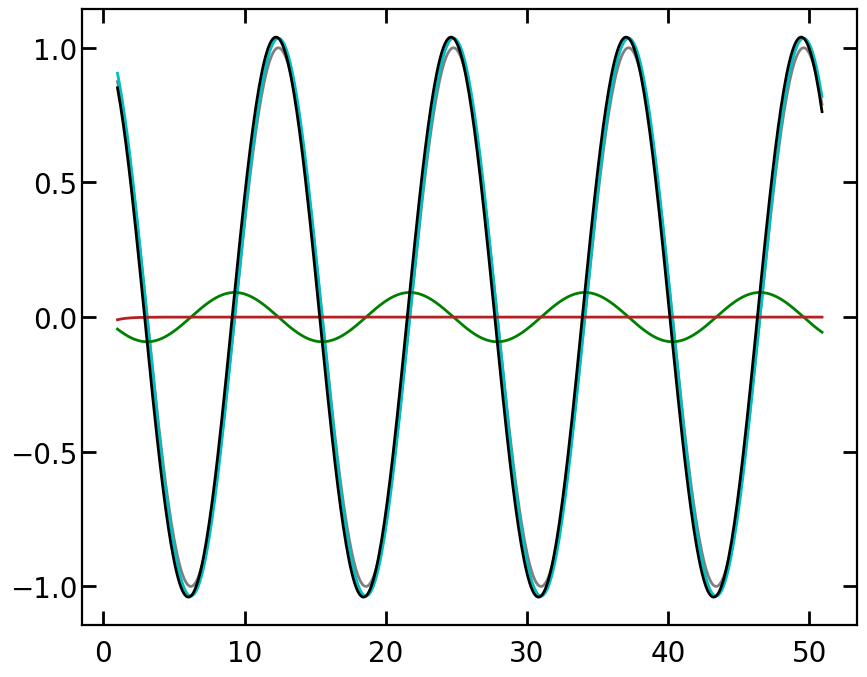

In [17]:
A=1
T = 12.4
omega_0 = 2 * np.pi / T
t = np.arange(1,51,0.1)
tau = 2759.97/3600
dev = A / (tau**2 * omega_0 **2 + 1)
g_B = 3. / (2 * B +1)
print(g_B)

term1 =  (tau**2 * omega_0**2 * g_B + 1) * np.cos(omega_0 * t) 
term2 =  tau * omega_0 * (1- g_B) * np.sin(omega_0 * t) 
term3 = tau**2 * omega_0**2 * (1 - g_B) * np.exp(-t/tau)  
up = dev * (term1 + term2 + term3) 
fig,ax=plt.subplots()
ax.plot(t,dev * term1,color='c')
ax.plot(t,dev * term2,color='green')
ax.plot(t,dev * term3,color='firebrick')
ax.plot(t,up,color='black')
ax.plot(t,A*np.cos(t*omega_0),color='grey',zorder=-10)
tau = 2759.97


print(np.max(up))

# short high resulution data
To mimic the drifter data we performed a simulation of inertial particles of 73h where we saved it location every 5 minutes. In addition we saved the fluid velocity field of the particle also every 5 minutes. 

In [77]:
basefile_inertia_short =  (base_directory + '{particle_folder}/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_short.zarr')

runtime =  timedelta(hours=73)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97

nparticles = 88347 # 52511

land_handling = 'anti_beaching'
ptype='MR'
starttime = datetime(2023, 9, 1, 0, 0, 0, 0)
endtime = starttime + runtime 
file = basefile_inertia_short.format(particle_folder=particle_folders[ptype],
                                       loc=loc,
                                       y_s=starttime.year,
                                       m_s=starttime.month,
                                       d_s=starttime.day,
                                       y_e=endtime.year,
                                       m_e=endtime.month,
                                       d_e=endtime.day,
                                       B = int(B * 1000), 
                                       tau = int(tau ),
                                       land_handling = land_handling)

ds_short = xr.open_dataset(file,
                             engine='zarr',
                             chunks={'trajectory':nparticles, 'obs':chunck_time},
                             drop_variables=['B','tau','z','vorticity'],
                             decode_times=False) #,decode_cf=False)


delta_t = 10./60 
U = zonal_dist(lon1 = ds_short[f'lon'][:,0:-2].values,
               lon2 = ds_short[f'lon'][:,2:].values,
               lat = ds_short[f'lat'][:,1:-1].values) / delta_t
U = np.insert(U,0,np.nan,axis=1)
U = np.insert(U,899,np.nan,axis=1)
    
V = meridional_dist(lat1 = ds_short[f'lat'][:,0:-2].values,
            lat2 = ds_short[f'lat'][:,2:].values) /delta_t
V = np.insert(V,0,np.nan,axis=1)
V = np.insert(V,899,np.nan,axis=1)

ds_short = ds_short.assign(U=(['trajectory','obs'],U))
ds_short = ds_short.assign(V=(['trajectory','obs'],V))
print(ds_short)

<xarray.Dataset> Size: 3GB
Dimensions:     (trajectory: 88347, obs: 900)
Coordinates:
  * obs         (obs) int32 4kB 0 1 2 3 4 5 6 7 ... 893 894 895 896 897 898 899
  * trajectory  (trajectory) int64 707kB 0 1 2 3 4 ... 88343 88344 88345 88346
Data variables:
    lat         (trajectory, obs) float32 318MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    lon         (trajectory, obs) float32 318MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    time        (trajectory, obs) float64 636MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    uf          (trajectory, obs) float32 318MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    vf          (trajectory, obs) float32 318MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    U           (trajectory, obs) float32 318MB nan -0.1091 -0.1454 ... nan nan
    V           (trajectory, obs) float32 318MB nan -1.255 -1.25 ... nan nan nan
Attributes: (12/14)
    Conventions:            CF-1.6/CF-1.7
    delta_x:    

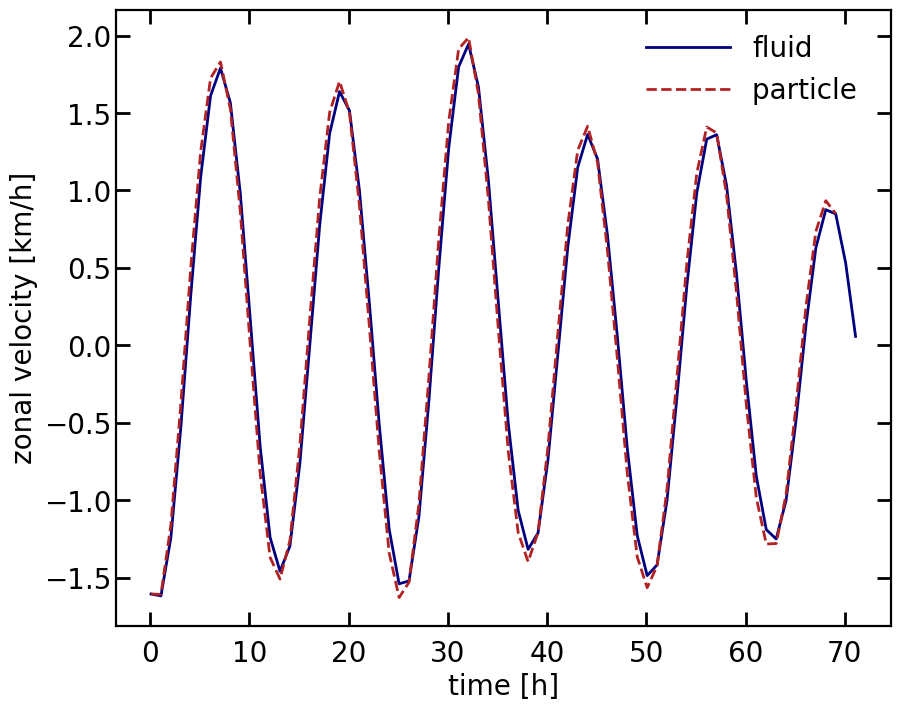

In [94]:
fig,ax=plt.subplots()
tlist= np.arange(0,73,1/12)
index = 866
ax.plot(tlist[1:72*12:12],ds_short.vf[index,1:72*12:12]*3.6,'-',color='navy')
ax.plot(tlist[1:70*12:12],ds_short.V[index,1:70*12:12],'--',color='firebrick')
ax.set_xlabel('time [h]')
ax.set_ylabel('zonal velocity [km/h]')
ax.legend(['fluid','particle '])

In [ ]:
# fourier spectrum
T = 12.4

Ttotal = 72 #hours
dt = 1/12 #hour
freq=np.arange(0,Ttotal,dt)*2*np.pi/Ttotal /dt

f_u_fluid = fft(ds_short.uf[index,1:72*12].values*3.6)
f_v_fluid = fft(ds_short.vf[index,1:72*12].values*3.6)
f_u_particle = fft(ds_short.U[index,1:72*12].values)
f_v_particle = fft(ds_short.V[index,1:72*12].values)

fig, ax = plt.subplots()
ax.plot(2 * np.pi/freq[1:300],np.abs(f_v_fluid[1:300]),'--o',color='navy')
ax.plot(2 * np.pi/freq[1:300],np.abs(f_v_particle[1:300]),'--s',color='firebrick')
ax.axvline(T, color='grey',zorder=-20)

Rmax_amplitude = np.max(np.abs(f_v_particle[1:300]))/np.max(np.abs(f_v_fluid[1:300]))
print(Rmax_amplitude)


fig2, ax2 = plt.subplots()
max_angle= 2* np.pi /360
ax2.plot(2 * np.pi / freq[1:25],np.angle(f_v_fluid)[1:25]/max_angle,'-o',color='navy',markersize=6)
ax2.plot(2 * np.pi / freq[1:25],(np.angle(f_v_particle)[1:25])/max_angle,'--s',color='firebrick',markersize=6)
ax3=ax2.twinx()
ax3.plot(2 * np.pi / freq[1:25],(np.angle(f_v_particle)[1:25]-np.angle(f_v_fluid)[1:25])/max_angle ,':d',color='green',markersize=6)

ax2.set_title('phase fourier spectrum')
# ax2.legend(['tracer','slow manifold MR','MR'])
ax2.legend(['MR'])
ax2.axvline(T, color='grey',zorder=-20)
ax2.axvline(2 * np.pi / freq[6], linestyle = '--',color='grey',zorder=-20)
ax2.set_xlim(0.,50)
phase_diff = (np.angle(f_v_particle)[6]-np.angle(f_v_fluid)[6])
print(phase_diff/(2 * np.pi) * 360)

NameError: name 'ds_short' is not defined